# Introduction
The project uses Keras and Tensorflow to build and train a CNN that can identify the breed of a dog in the supplied image. The problem is supervised multiclass classification problem. 

## Setting up Kaggle API

In [1]:
# Adding Kaggle json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jacwalters","key":"102247c3b5199865d9db209767169569"}'}

Initialising Kaggle API client using the uploaded key. 

In [2]:
!pip install -q kaggle

In [3]:
# Move file to kaglel folder and give permissions to avoid warning
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

# permissions
!chmod 600 ~/.kaggle/kaggle.json

Creating the directory to store the data

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# search kaggle for the dataset needed
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           3570          7  0.1764706        


In [6]:
# download the data
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 686M/691M [00:19<00:00, 24.6MB/s]
100% 691M/691M [00:19<00:00, 36.7MB/s]
/content


In [ ]:
# Removing the data that is not needed 
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset # unzip into dog dataset folder
!rm dog_dataset/dogbreedidfromcomp.zip  # remove folder after unzipping
!rm dog_dataset/sample_submission.csv # remove the sample submission file provided by kaggle

## Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm import tqdm 
from keras.preprocessing import image 
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D 
import keras.utils as image
from keras.optimizers import SGD
from keras.optimizers import Adam 

In [9]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


* There are 10,222 rows and two columns. There are four different breeds of dog in the datase. 
* Let us find out the number of each breed available in the provided dataset. 

In [10]:
breeds_all = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

The model training will be limited to three breeds due to the limited access to computation power. 

In [11]:
def assign_class_names(df):
    # list selected classes
    CLASS_NAMES = ["scottish_deerhound", "maltese_dog", "entlebucher"]
    
    # include only listed breeds
    labels = df[(df['breed'].isin(CLASS_NAMES))]
    labels = labels.reset_index()
    
    return labels

labels = assign_class_names(labels_all)

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   358 non-null    int64 
 1   id      358 non-null    object
 2   breed   358 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.5+ KB


In [12]:
 CLASS_NAMES = ["scottish_deerhound", "maltese_dog", "entlebucher"]
 
 # Prepare data for training
def feature_preparation(filepath, df, breed_list):
    # create numpy matrix of zeroes
    X_data = np.zeros((len(df), 224, 224, 3), dtype='float32')
    
    # One Hot Encoding
    Y_data = label_binarize(df['breed'], classes = breed_list )
    
    # Convert image to numpy array and normalize data
    for i in tqdm(range(len(df))):
        img = image.load_img(filepath % df['id'][i], target_size=(224, 224))
        img = image.img_to_array(img)
        x = np.expand_dims(img.copy(), axis=0)
        X_data[i] = x / 255.0
        
        
    print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
    print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))
    
    return X_data, Y_data

    #/content/dog_dataset/train

X_data, Y_data = feature_preparation('dog_dataset/train/%s.jpg', labels, CLASS_NAMES)

100%|██████████| 358/358 [00:01<00:00, 266.68it/s]


Train Images shape:  (358, 224, 224, 3)  size: 53,889,024
One-hot encoded output shape:  (358, 3)  size: 1,074


In [25]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 24, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 24)        37656     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 24)      

In [26]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [27]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 3s 669ms/step - loss: 5.2165 - accuracy: 0.3463 - val_loss: 5.1784 - val_accuracy: 0.3231
Epoch 2/100
3/3 [==============================] - 1s 221ms/step - loss: 5.1661 - accuracy: 0.3696 - val_loss: 5.1344 - val_accuracy: 0.2923
Epoch 3/100
3/3 [==============================] - 0s 151ms/step - loss: 5.1228 - accuracy: 0.3385 - val_loss: 5.0933 - val_accuracy: 0.2923
Epoch 4/100
3/3 [==============================] - 0s 153ms/step - loss: 5.0819 - accuracy: 0.3268 - val_loss: 5.0529 - val_accuracy: 0.2923
Epoch 5/100
3/3 [==============================] - 1s 192ms/step - loss: 5.0393 - accuracy: 0.3230 - val_loss: 5.0106 - val_accuracy: 0.2923
Epoch 6/100
3/3 [==============================] - 0s 151ms/step - loss: 4.9962 - accuracy: 0.3541 - val_loss: 4.9697 - val_accuracy: 0.3846
Epoch 7/100
3/3 [==============================] - 0s 152ms/step - loss: 4.9545 - accuracy: 0.4436 - val_loss: 4.9309 - val_accuracy: 0.3692
Epoch 8/100
3

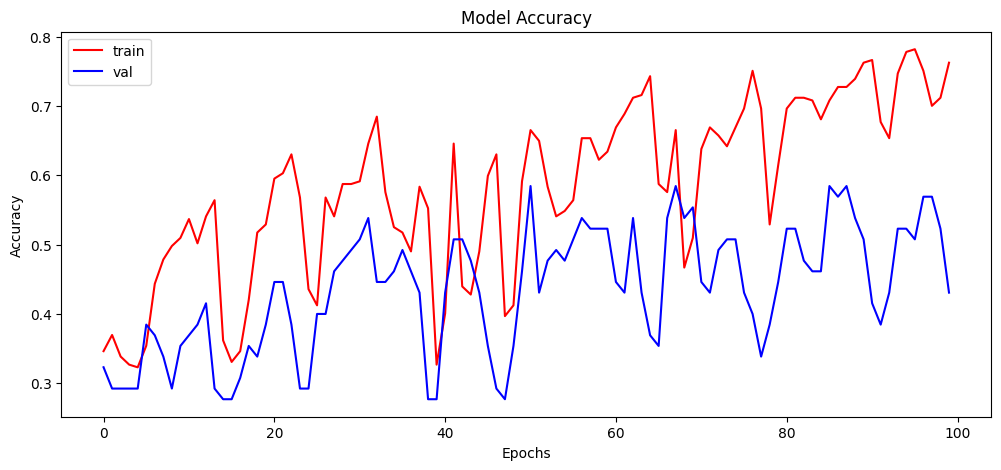

In [28]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [29]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 10ms/step - loss: 2.8679 - accuracy: 0.6944
Accuracy over the test set: 
  69.44 %


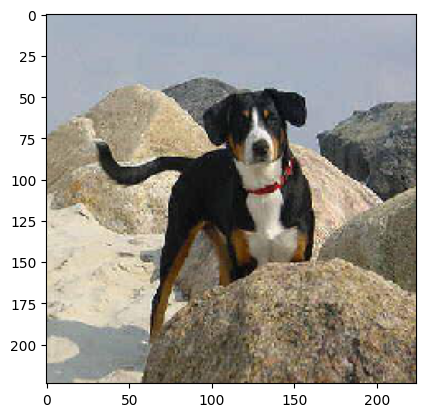

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [30]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [31]:
model.save("dog_breed.h5")